In [ ]:
import sys
import collections
import csv
import gzip
import os
import json
import subprocess
import statistics
import operator
from multiprocessing import Pool as ThreadPool 
import os.path
import time
import random
import pandas as pd
from tqdm import tqdm

In [ ]:
## download new data outside of expected range

In [ ]:
df = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/05-25-2023/noNA_distinct_cleaned_combined.csv')
df

top10 = [27, 78, 14, 1, 15, 2, 17, 20, 106, 5]
out_of_top10_df = df[~df['ribotype'].isin(top10)]

# get ribotypes that appear >50 times! ## [23, 18, 39, 12, 26, 10, 126]
more50_list = out_of_top10_df['ribotype'].value_counts().loc[lambda x: x>90].reset_index()['index'].tolist()

OOR_df = out_of_top10_df[out_of_top10_df['ribotype'].isin(more50_list)]
OOR_df # 500 things

In [ ]:
n_threads = 4

global directory
directory = '/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_reads/'
invalids = list()


def mapping(SRA_ID):
    ## get FTP link(s)

    info = True
    invalids = list()
    try:
        subprocess.check_output('ffq ' + SRA_ID + ' -o ' + SRA_ID + '.json 2>&1', shell=True)
        pbar.update(1)
    except:
        info = False  
    
    ## extract links from json file
    if info:
        f = open(SRA_ID + '.json')
        data = json.load(f)
        l_links = list()
        
        if SRA_ID[0:3] == "ERS":
            for k,v in data[SRA_ID]['experiments'].items():
                name = k
            for k,v in data[SRA_ID]['experiments'][name]['runs'].items():
                err_name = k
            file_name = data[SRA_ID]['experiments'][name]['runs'][err_name]
        else:
            file_name = data[SRA_ID]
        
        #for d in data[SRA_ID]['files']['ftp']:
        for d in file_name['files']['ftp']:
            if d['filetype'] == 'fastq':
                link = d['url']
                l_links.append(link)
    
        ## case no link or more than 2 links
        if not l_links or len(l_links) > 2:
            print('error: found ' + str(len(l_links)) + ' FTP links for run ' + SRA_ID)
    
        else:
            ## download reads
            for link in l_links:
                if '_1.fastq.gz' in link:
                    subprocess.check_output('wget ' + link + ' -O ' + directory + SRA_ID + '_1.fastq.gz 2>&1', shell=True)
                elif '_2.fastq.gz' in link:
                    subprocess.check_output('wget ' + link + ' -O ' + directory + SRA_ID + '_2.fastq.gz 2>&1', shell=True)
                else:
                    subprocess.check_output('wget ' + link + ' -O ' + directory + SRA_ID + '.fastq.gz 2>&1', shell=True)

        
        os.system('rm ' + SRA_ID + '.json')
        time.sleep(2)
    
    else:
        print('error: the SRA ID ' + SRA_ID + ' seems invalid')
        invalids.append(SRA_ID)
        

l_final = OOR_df['accession'].tolist()
pbar = tqdm(total=len(l_final))

## process samples        
pool = ThreadPool(n_threads) 
tmp_res = pool.map_async(mapping, l_final, chunksize=None)
output = tmp_res.get()
pool.close() 
pool.join()

In [ ]:
## checking about the downloaded files

valid_list1 = list()
valid_list2 = list()
ending = '_1.fastq.gz'
ending2 = '_2.fastq.gz'

for file in os.listdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_reads/'):
    if file.endswith(ending):
        filename = file.replace(ending, "")
        valid_list1.append(filename)
    if file.endswith(ending2):
        filename = file.replace(ending2, "")
        valid_list2.append(filename)
    
    if len(valid_list1) == len(valid_list2):
        SRA_ID_list = valid_list1
    else:
        if len(valid_list1) > len(valid_list2):
            SRA_ID_list = valid_list2
        else:
            SRA_ID_list = valid_list1

In [ ]:
OOR_df[OOR_df['accession'].isin(SRA_ID_list)].to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_data.csv')

In [ ]:
## kmer counting

In [ ]:
import sys
import subprocess
import os
import pandas as pd
from multiprocessing import Pool as ThreadPool 

os.chdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/')

        
df = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_data.csv')
# subset to only top three ribotypes
# df = df[(df['ribotype'] == 27) | (df['ribotype'] == 78) | (df['ribotype'] == 14)]
SRA_ID_list = df['accession'].tolist()

kmer_size = 21
n_threads = 4

def mapping(accession):
    filename = accession+'_1.fastq.gz'
    try:
        subprocess.check_output('kmc -k' + str(kmer_size) + ' ' + 'OOR_reads/' + filename + ' kmer_'+str(kmer_size)+'/' + filename + ' tmp', shell=True)
        subprocess.check_output('kmc_tools transform kmer_'+str(kmer_size)+'/'+filename+ ' dump kmer_'+str(kmer_size)+'_txt/' + accession+'_1.txt', shell=True)
    except subprocess.CalledProcessError as error:
        sys.stdout.write("%s\n" % (str(error)))
    
    filename = accession+'_2.fastq.gz'
    try:
        subprocess.check_output('kmc -k' + str(kmer_size) + ' ' + 'OOR_reads/' + filename + ' kmer_'+str(kmer_size)+'/' + filename + ' tmp', shell=True)
        subprocess.check_output('kmc_tools transform kmer_'+str(kmer_size)+'/'+filename+ ' dump kmer_'+str(kmer_size)+'_txt/' + accession+'_2.txt', shell=True)
    except subprocess.CalledProcessError as error:
        sys.stdout.write("%s\n" % (str(error)))
        
    pbar.update(1)

pbar = tqdm(total=len(SRA_ID_list))

## process samples        
pool = ThreadPool(n_threads) 
tmp_res = pool.map_async(mapping, SRA_ID_list, chunksize=None)
output = tmp_res.get()
pool.close() 
pool.join() 

Stage 1: 0%/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
Stage 1: 100%
in1: 100% 
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
Stage 2: 99%*

Command 'kmc -k21 OOR_reads/SRR3629545_2.fastq.gz kmer_21/SRR3629545_2.fastq.gz tmp' died with <Signals.SIGABRT: 6>.


  2%|▏         | 8/500 [21:38<5:40:29, 41.52s/it]*terminate called after throwing an instance of 'CThreadCancellationException'
**/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
***********
Stage 1: 100%
***********************************************************
Stage 1: 100%


Command 'kmc -k21 OOR_reads/SRR3337591_1.fastq.gz kmer_21/SRR3337591_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


Stage 2: 54%/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
/bin/sh: which: line 1: syntax erro

Command 'kmc -k21 OOR_reads/SRR6009530_1.fastq.gz kmer_21/SRR6009530_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


Stage 2: 58%/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
Stage 2: 100%
***/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
**/bin/sh: which: line 1: syntax

Command 'kmc -k21 OOR_reads/SRR3629728_2.fastq.gz kmer_21/SRR3629728_2.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


  3%|▎         | 17/500 [23:11<1:35:22, 11.85s/it]

Command 'kmc -k21 OOR_reads/SRR3356190_1.fastq.gz kmer_21/SRR3356190_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.
Command 'kmc -k21 OOR_reads/SRR3356190_2.fastq.gz kmer_21/SRR3356190_2.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


  2%|▏         | 12/500 [23:20<2:54:13, 21.42s/it]

Command 'kmc -k21 OOR_reads/ERR347597_1.fastq.gz kmer_21/ERR347597_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


  4%|▍         | 19/500 [23:33<1:30:00, 11.23s/it]

Command 'kmc -k21 OOR_reads/SRR3629627_1.fastq.gz kmer_21/SRR3629627_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


  5%|▌         | 25/500 [24:31<1:17:36,  9.80s/it]

Command 'kmc -k21 OOR_reads/SRR6009233_1.fastq.gz kmer_21/SRR6009233_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.
Command 'kmc -k21 OOR_reads/SRR6009233_2.fastq.gz kmer_21/SRR6009233_2.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


  4%|▎         | 18/500 [24:42<1:56:55, 14.55s/it]

Command 'kmc -k21 OOR_reads/SRR3629755_2.fastq.gz kmer_21/SRR3629755_2.fastq.gz tmp' died with <Signals.SIGABRT: 6>.


  5%|▌         | 26/500 [24:44<1:25:41, 10.85s/it]

Command 'kmc -k21 OOR_reads/SRR6009237_1.fastq.gz kmer_21/SRR6009237_1.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.
Command 'kmc -k21 OOR_reads/SRR6009237_2.fastq.gz kmer_21/SRR6009237_2.fastq.gz tmp' died with <Signals.SIGSEGV: 11>.


 57%|█████▋    | 283/500 [1:10:49<41:17, 11.42s/it]Process ForkPoolWorker-43:
Process ForkPoolWorker-44:
Process ForkPoolWorker-45:
Traceback (most recent call last):
  File "/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/rds/general/user/dds122/home/a

In [74]:
valid_list1 = list()
valid_list2 = list()
ending = '_1.txt'
ending2 = '_2.txt'

for file in os.listdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_21_txt/'):
    if file.endswith(ending):
        filename = file.replace(ending, "")
        valid_list1.append(filename)
    if file.endswith(ending2):
        filename = file.replace(ending2, "")
        valid_list2.append(filename)
        
notinlist2 = list(set(valid_list1) - set(valid_list2))
listtouse = list(set(valid_list1) - set(notinlist2))

*******************
Stage 1: 100%
Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

In [76]:
len(listtouse) # 304

***************************


304

Stage 1: 100%
Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
*********************************

In [ ]:
## check against library k-mers 

In [79]:
global kmer_2_id
kmer_2_id = dict()
file_content = csv.reader(open('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/05-25-2023/kmer_id'+str(kmer_size)+'.csv'), delimiter=',')
for line in file_content:
    kmer = line[0]
    id_ = line[1]
    kmer_2_id[kmer] = id_

Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
***********************************************

In [ ]:
kmer_2_id

Stage 1: 100%
Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
*********************************

In [94]:
import sys
import subprocess
import os
import csv
from multiprocessing import Pool as ThreadPool  
import collections
from tqdm import tqdm


kmer_size = 21 # ACTIONABLE: to be declared
os.chdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_21_txt/')
n_threads = 4

# load library kmers
global kmer_2_id
file_content21 = open("/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/k21_col_list.txt", "r") 
data21 = file_content21.read() 
kmers21 = data21.split("\n")
kmers_list = kmers21[:-1]
kmer_2_id = dict.fromkeys(kmers_list)


def create_csv(accession):
    id_count = collections.defaultdict(int)
    
    file = accession+'_1.txt'
    
    output = open(file, "r")
    Lines = output.readlines()
    for line in Lines:
        insert = line.strip().split('\t')
        if insert and len(insert) == 2:
            kmer = insert[0]
            if kmer in kmer_2_id:
                id_count[kmer] = 1
    
    try:
        output = open(file.replace('_1.txt','_2.txt'), "r")
        Lines = output.readlines()
        for line in Lines:
            insert = line.strip().split('\t')
            if insert and len(insert) == 2:
                kmer = insert[0]
                if kmer in kmer_2_id:
                    id_count[kmer] = 1
    except:
        print('Error with file ' + file.replace('_1.txt','_2.txt'))

    out = open('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_21_df/' + accession + '.txt', 'w+')
    for id_, count_ in id_count.items():
        out.write(str(id_) + '	' + str(count_) + '\n')
    out.close()

    
    pbar.update(1)
    

pbar = tqdm(total=len(listtouse))


## process samples        
pool = ThreadPool(n_threads) 
tmp_res = pool.map_async(create_csv, listtouse)
output = tmp_res.get()
pool.close() 
pool.join() 


  0%|          | 0/304 [27:43<?, ?it/s]
Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
******

In [ ]:
## check against library k-mers 

In [ ]:
## consolidate into single file

In [96]:
################################################## get unique kmers in library ##############################################################
#### get kmers that are unique to ribotype in library
import sys
import subprocess
import pandas as pd
import os
import csv
from multiprocessing import Pool as ThreadPool  
import collections
from collections import Counter
from tqdm import tqdm

# initialize
kmer_size = 21 # ACTIONABLE: to be declared
os.chdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_'+str(kmer_size)+'_txt/')
n_threads = 4

# load library kmers
global library_kmer_2_id
file_content21 = open("/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/k21_col_list.txt", "r") 
data21 = file_content21.read() 
kmers21 = data21.split("\n")
kmers_list = kmers21[:-1]
library_kmer_2_id = dict.fromkeys(kmers_list)
    
################################################## get kmers in read files ##############################################################
# combine all txt one huge dictionary
import json
import os
import math
from tqdm import tqdm

# Define output filename
OutputFilename = 'new10_kmer'+str(kmer_size)+'_dict.txt'

# Define path to input and output files
InputPath  = '/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_'+str(kmer_size)+'_df/'
OutputPath = '/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/'

# Define output file
out_file = os.path.join(OutputPath,OutputFilename)

readfile_dict = dict()

# Loop through each file in input directory
for fn in tqdm(os.listdir(InputPath)):
    # Define full filename
    in_file = os.path.join(InputPath,fn)
    if os.path.isfile(in_file) and fn.endswith('.txt'):
        with open(in_file, 'r') as file_in:
            content = file_in.readlines()
            id_present = collections.defaultdict(int)
            for line in content:
                insert = line.strip().split('\t')
                kmer_ = insert[0]
                if kmer_ in library_kmer_2_id: # if kmer exists in library; replacing it with shrunk_library_id_2_ribotype does not give sane result!
                      id_present[kmer_] = 1
                        
                missing_kmers = list(set(library_kmer_2_id.keys()) - set(id_present.keys()))
                for missing_kmer in missing_kmers:
                    id_present[missing_kmer] = 0
                    
            if len(id_present) != 0:
                readfile_dict[fn.replace('.txt', '')] = id_present

# save to txt file
out = open(out_file, 'w+')
for id_, presence_ in id_present.items():
    out.write(str(id_) + '	' + str(presence_) + '\n')
out.close()     


Stage 2: 100%
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
in1: 100% 
/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: scl: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `scl'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'
***********************************************

In [ ]:

################################################## get per kmer counts of unique k-mers per readfile ##############################################################
readfile_by_kmer = dict()

for k, v in readfile_dict.items(): # for every readfile
    kmer_count = collections.defaultdict(int)
    for id_, presence_ in v.items():
        kmer_list = list(library_kmer_2_id.keys())
        id_list = list(library_kmer_2_id.values())
        kmer_position = id_list.index(id_)
        kmer_ = kmer_list[kmer_position]
        extracted_count = presence_
        #extracted_count = int(extracted_count)
        kmer_count[kmer_] = extracted_count

    missing_kmers = list(set(library_kmer_2_ribotype.keys()) - set(kmer_count.keys()))
    for missing_kmer in missing_kmers:
        kmer_count[missing_kmer] = 0
    
    readfile_by_kmer[k] = kmer_count
    

In [ ]:
################################################## account for files with no kmers belonging to library ##############################################################
for file in os.listdir('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/kmer_'+str(kmer_size)+'_df/'):
    filename = file.replace('.txt', '')
    if filename not in readfile_by_kmer.keys() and file.endswith('.txt'):
        kmer_count = collections.defaultdict(int)
        for kmer_ in library_kmer_2_ribotype.keys():
            kmer_count[kmer_] = 0 # tried w 0
        readfile_by_kmer[filename] = kmer_count


In [112]:
################################################## export data in x and y, ready for prediction ##############################################################

# prep and export x data 
#X = pd.DataFrame.from_dict(readfile_by_kmer,orient='index')
X = pd.DataFrame.from_dict(readfile_dict,orient='index')
X = X.reindex(columns = kmers_list)

X

,AAAGCTGATAACTTTCTAAAA,AAATGTTATATAATCTATATC,AAATTCTAATGATATAGATTA,AACTTTCTAAAATTATCGAAG,AAGCTGATAACTTTCTAAAAT,AATCTATATCATTAGAATTTA,AATGATATAGATTATATAACA,AATGTTATATAATCTATATCA,AATTCTAATGATATAGATTAT,AATTTTAGAAAGTTATCAGCT,...,CAATTAGCACCTTGAGCAACA,ACAGAATAAACTGAACGTATG,AACCTGAATCGCCAGCGGCAT,GACAAGCTATGTGCGTTAGCA,AGTTTCACCAGTTTTGATTTA,ATCCGTTGGCGCTGTGTGTTA,CTAGATAAATCGAAGATTTAA,GATAAACTGAACGCATGTGAA,CATCTCCACCATTTAAGAGCA,ACTAGCACTTTAAGCAACAGA
SRR3629440,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
SRR6009475,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR3338621,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR6009709,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR3335252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3629647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ERR3473796,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0
SRR3629682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ERR3465387,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [113]:
X.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/10ribo_X_readfile_by_kmer_absence_df_k'+str(kmer_size)+'.csv', index = True, header = True)

In [114]:
df = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/OOR_data.csv', index_col=0)
df = df.loc[df['accession'].isin(readfile_dict.keys())] 
df = df.drop(columns='source_code')
df = df.set_index('accession')
df.index.name = None
Y = df.loc[X.index]

In [115]:
Y

,ribotype
SRR3629440,26
SRR6009475,23
SRR3338621,23
SRR6009709,39
SRR3335252,26
...,...
SRR3629647,26
ERR3473796,23
SRR3629682,18
ERR3465387,23


In [116]:
Y.to_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/10ribo_Y_readfile_by_all_kmer_trueribotype_df_k'+str(kmer_size)+'.csv', index = True, header = True)

In [117]:
## run through l1
import joblib

model21 = joblib.load('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/10-30-2023/k21_all_binary_l1.joblib')
pred_ribo = model21.predict(X)

/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/rds/general/user/dds122/home/anaconda3/envs/r413/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator OneVsOneClassifier from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [121]:
import numpy as np

ovo_decision = model21.decision_function(X)

votes = np.round(ovo_decision)
normalized_confidences = ovo_decision - votes

In [133]:
print(normalized_confidences[0])

[ 0.24758718  0.28989646  0.30460253  0.24945647  0.30833844 -0.31930254
 -0.11294852  0.1891803  -0.3128883   0.21376461]


In [131]:
oor_max_p = list()
for i in normalized_confidences:
    oor_max_p.append(max(i))

In [132]:
Y['max_p'] = oor_max_p

In [137]:
inrange_X = pd.read_csv('/rds/general/project/hda-22-23/live/Summer_projects/dds122/data/05-25-2023/10ribo_X_train_readfile_by_all_absence_df_k'+str(kmer_size)+'.csv', index_col = 0)

In [138]:
inrange_X

,AAAGCTGATAACTTTCTAAAA,AAATGTTATATAATCTATATC,AAATTCTAATGATATAGATTA,AACTTTCTAAAATTATCGAAG,AAGCTGATAACTTTCTAAAAT,AATCTATATCATTAGAATTTA,AATGATATAGATTATATAACA,AATGTTATATAATCTATATCA,AATTCTAATGATATAGATTAT,AATTTTAGAAAGTTATCAGCT,...,CAATTAGCACCTTGAGCAACA,ACAGAATAAACTGAACGTATG,AACCTGAATCGCCAGCGGCAT,GACAAGCTATGTGCGTTAGCA,AGTTTCACCAGTTTTGATTTA,ATCCGTTGGCGCTGTGTGTTA,CTAGATAAATCGAAGATTTAA,GATAAACTGAACGCATGTGAA,CATCTCCACCATTTAAGAGCA,ACTAGCACTTTAAGCAACAGA
ERR2232524,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3358263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR3355860,0,1,1,0,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
ERR031697,0,1,1,0,0,1,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
SRR7309037,1,0,0,1,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3357915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR6009429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ERR126241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
SRR7309242,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [139]:
inrange_ovo_decision = model21.decision_function(inrange_X)

inrange_votes = np.round(inrange_ovo_decision)
inrange_normalized_confidences = inrange_ovo_decision - inrange_votes

In [140]:
print(inrange_normalized_confidences[0])

[-0.31258801 -0.25516901 -0.29884067  0.3249307  -0.22179118 -0.31521643
  0.32655816 -0.22818103 -0.31778093 -0.31568045]


In [141]:
inrange_max_p = list()
for i in inrange_normalized_confidences:
    inrange_max_p.append(max(i))

In [147]:
inrange_Y = pd.DataFrame(index=inrange_X.index) 
inrange_Y['max_p'] = inrange_max_p

In [155]:
oorange_Y = Y.drop('ribotype', axis = 1)
oorange_Y['type'] = 'oorange'
oorange_Y

,max_p,type
SRR3629440,0.308338,oorange
SRR6009475,0.318731,oorange
SRR3338621,0.320389,oorange
SRR6009709,0.321113,oorange
SRR3335252,0.320845,oorange
...,...,...
SRR3629647,0.323692,oorange
ERR3473796,0.312244,oorange
SRR3629682,0.314053,oorange
ERR3465387,0.317303,oorange


In [151]:
inrange_Y['type'] = 'inrange'
inrange_Y

,max_p,type
ERR2232524,0.326558,inrange
SRR3358263,0.326944,inrange
SRR3355860,0.327151,inrange
ERR031697,0.327222,inrange
SRR7309037,0.324391,inrange
...,...,...
SRR3357915,0.327464,inrange
SRR6009429,0.326483,inrange
ERR126241,0.327368,inrange
SRR7309242,0.325381,inrange


In [156]:
comb_Y = pd.concat([oorange_Y, inrange_Y])
comb_Y

,max_p,type
SRR3629440,0.308338,oorange
SRR6009475,0.318731,oorange
SRR3338621,0.320389,oorange
SRR6009709,0.321113,oorange
SRR3335252,0.320845,oorange
...,...,...
SRR3357915,0.327464,inrange
SRR6009429,0.326483,inrange
ERR126241,0.327368,inrange
SRR7309242,0.325381,inrange


<Axes: xlabel='type', ylabel='max_p'>

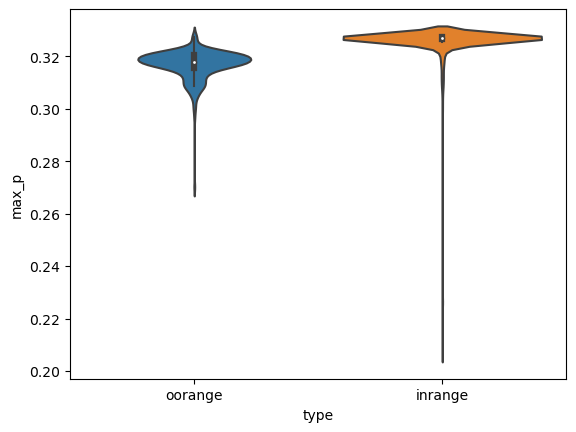

In [157]:
import seaborn as sns
sns.violinplot(x="type", y="max_p", data=comb_Y)

In [158]:
## tried with averaged p?

inrange_ovo_decision = model21.decision_function(inrange_X)

inrange_votes = np.round(inrange_ovo_decision)
inrange_normalized_confidences = inrange_ovo_decision - inrange_votes
inrange_max_p = list()
for i in inrange_normalized_confidences:
    inrange_max_p.append(np.mean(i))